In [3]:
from seqCNN_model import CNNLSTM, ComplexCNNFeatureExtractor
from NegPearCor import NegativePearsonCorrelation
from seqCNN_training import train_and_validate_cnnlstm
from seqCNN_test import test_cnnlstm
from GradCAM import GradCAM, visualize_gradcam
from CNN_dataset import WindowedUBFCPhysDataset
# from CNN_dataset_augmented import WindowedUBFCPhysDataset


import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import random
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


### Data loading and training

In [4]:
train_dir = "/work/AML_Project/5_Models/PhysNEt/DataSet/Train_norm"
test_dir = "/work/AML_Project/5_Models/PhysNEt/DataSet/Test_norm"
val_dir = "/work/AML_Project/5_Models/PhysNEt/DataSet/Validation_norm"

num_epochs = 10
learning_rate = 0.001
weight_decay = 0.0001
window_size = 20
stride = 15
batch_size = 16

train_dataset = WindowedUBFCPhysDataset(root_dir=train_dir,
                                        window_size=window_size,
                                        stride=stride)
val_dataset   = WindowedUBFCPhysDataset(root_dir=val_dir,
                                        window_size=window_size,
                                        stride=stride)
test_dataset   = WindowedUBFCPhysDataset(root_dir=test_dir,
                                        window_size=window_size,
                                        stride=stride)
#datasets for augmented data

# train_dataset = WindowedUBFCPhysDataset(root_dir=train_dir,
#                                         window_size=window_size,
#                                         stride=stride, p=0.7,isTrain=True)
# val_dataset   = WindowedUBFCPhysDataset(root_dir=val_dir,
#                                         window_size=window_size,
#                                         stride=stride, p=0.0 ,isTrain=False)
# test_dataset   = WindowedUBFCPhysDataset(root_dir=test_dir,
#                                         window_size=window_size,
#                                         stride=stride, p=0.0,isTrain=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

wandb.init(project="Seq_CNN_12345", entity="aml-final-project")

cnn_feature_extractor = ComplexCNNFeatureExtractor()
model = CNNLSTM(cnn_feature_extractor, hidden_size=128)

# choose criterion
criterion = nn.MSELoss()
# criterion = NegativePearsonCorrelation()


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=5,
        verbose=True
    )

# Train with early stopping
train_losses, val_losses, first_epoch_preds, last_epoch_preds = train_and_validate_cnnlstm(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
    device = device
)

/home/ucloud/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/work/AML_Project/5_Models/CNN_dataset.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't hav

Epoch 1/10, Train Loss: 0.4928
Validation Loss: 1.9276
Best model updated based on validation loss.
Epoch 2/10, Train Loss: 0.5155
Validation Loss: 1.6755
Best model updated based on validation loss.
Epoch 3/10, Train Loss: 0.5624
Validation Loss: 1.5315
Best model updated based on validation loss.
Epoch 4/10, Train Loss: 0.5543
Validation Loss: 1.5862
Epoch 5/10, Train Loss: 0.5631
Validation Loss: 2.0168
Epoch 6/10, Train Loss: 0.6307
Validation Loss: 1.6824
Epoch 7/10, Train Loss: 0.6145
Validation Loss: 1.5776
Epoch 8/10, Train Loss: 0.6249
Validation Loss: 1.6394
Epoch 9/10, Train Loss: 0.6541
Validation Loss: 1.8270
Epoch 10/10, Train Loss: 0.9072
Validation Loss: 1.2921
Best model updated based on validation loss.


Epoch,▁▂▃▁▂▃▃▄▅▆▆▇█
Learning Rate,███████████▁▁
Train Loss,▁▁▁▅▅▅▅▅▆▆▆▆█
Validation Loss,▁▁▁█▇▆▆█▇▆▇▇▅
Epoch,10
Learning Rate,0.0001
Train Loss,0.90722
Validation Loss,1.2921


### Train and validation plots

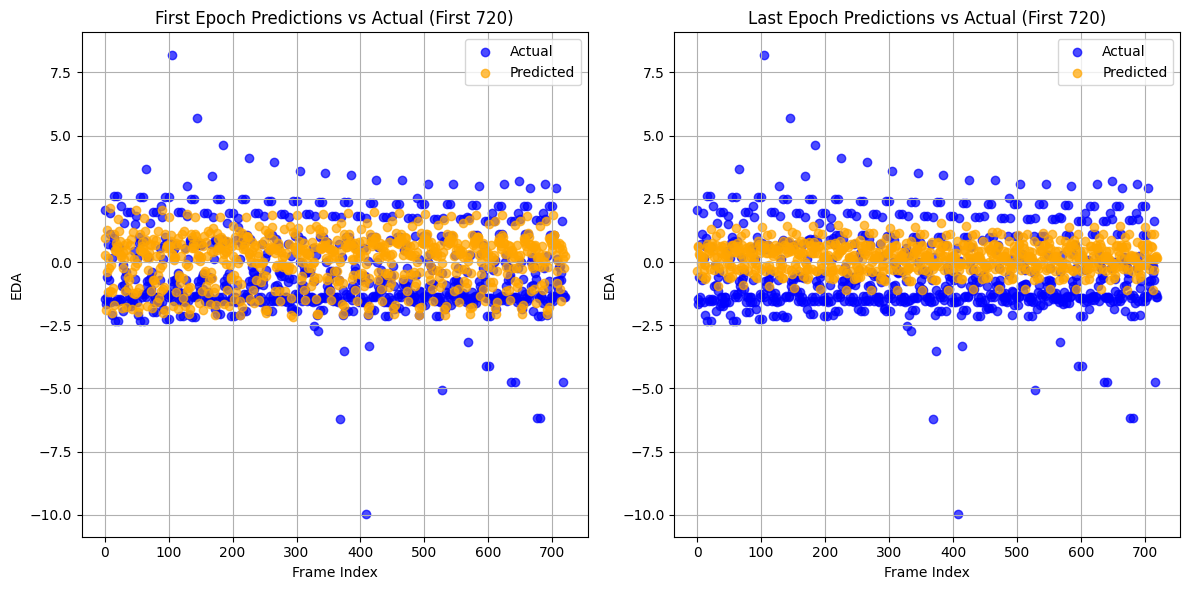

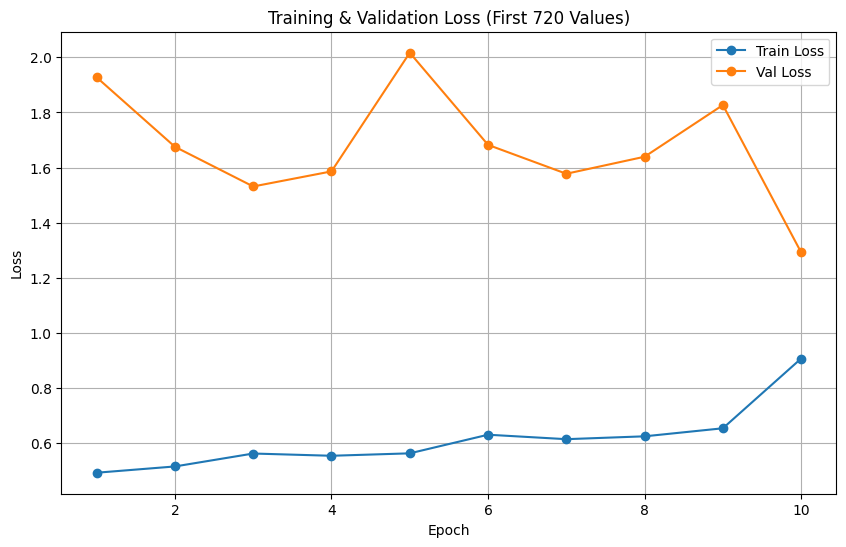

In [5]:
def plot_predictions_vs_actuals(y_true_first, y_pred_first, y_true_last, y_pred_last, limit=720):
    plt.figure(figsize=(12, 6))

    # Limit data to the first 720 values
    y_true_first = y_true_first[:limit]
    y_pred_first = y_pred_first[:limit]
    y_true_last = y_true_last[:limit]
    y_pred_last = y_pred_last[:limit]

    # First epoch
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(y_true_first)), y_true_first, color='blue', alpha=0.7, label='Actual')
    plt.scatter(range(len(y_pred_first)), y_pred_first, color='orange', alpha=0.7, label='Predicted')
    plt.title("First Epoch Predictions vs Actual (First 720)")
    plt.xlabel("Frame Index")
    plt.ylabel("EDA")
    plt.legend()
    plt.grid(True)

    # Last epoch
    plt.subplot(1, 2, 2)
    plt.scatter(range(len(y_true_last)), y_true_last, color='blue', alpha=0.7, label='Actual')
    plt.scatter(range(len(y_pred_last)), y_pred_last, color='orange', alpha=0.7, label='Predicted')
    plt.title("Last Epoch Predictions vs Actual (First 720)")
    plt.xlabel("Frame Index")
    plt.ylabel("EDA")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_predictions_vs_actuals(
    first_epoch_preds["true"], 
    first_epoch_preds["pred"], 
    last_epoch_preds["true"], 
    last_epoch_preds["pred"]
)
def plot_loss_curves(train_losses, val_losses, limit=720):
    # Adjust for the limit
    train_losses = train_losses[:limit]
    val_losses = val_losses[:limit]
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, marker='o', label='Train Loss')
    plt.plot(epochs, val_losses, marker='o', label='Val Loss')
    plt.title(f"Training & Validation Loss (First {limit} Values)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curves(train_losses, val_losses, limit=720)


### Test loss

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# test run
test_loss, test_metrics, preds, true = test_cnnlstm(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device,
    log_predictions=True  
)

Test Loss: 0.0790, MAE: 0.8901, RMSE: 1.1237


### GradCAM

Processing Batches:   0%|          | 0/90 [00:00<?, ?it/s]/work/AML_Project/5_Models/CNN_dataset.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(fpath

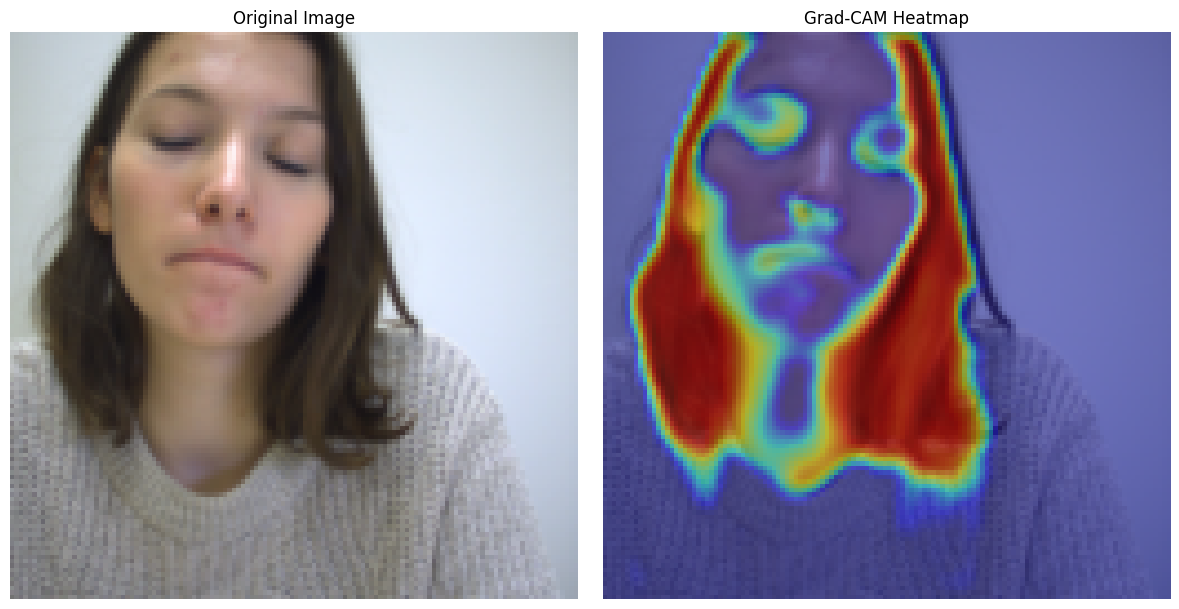

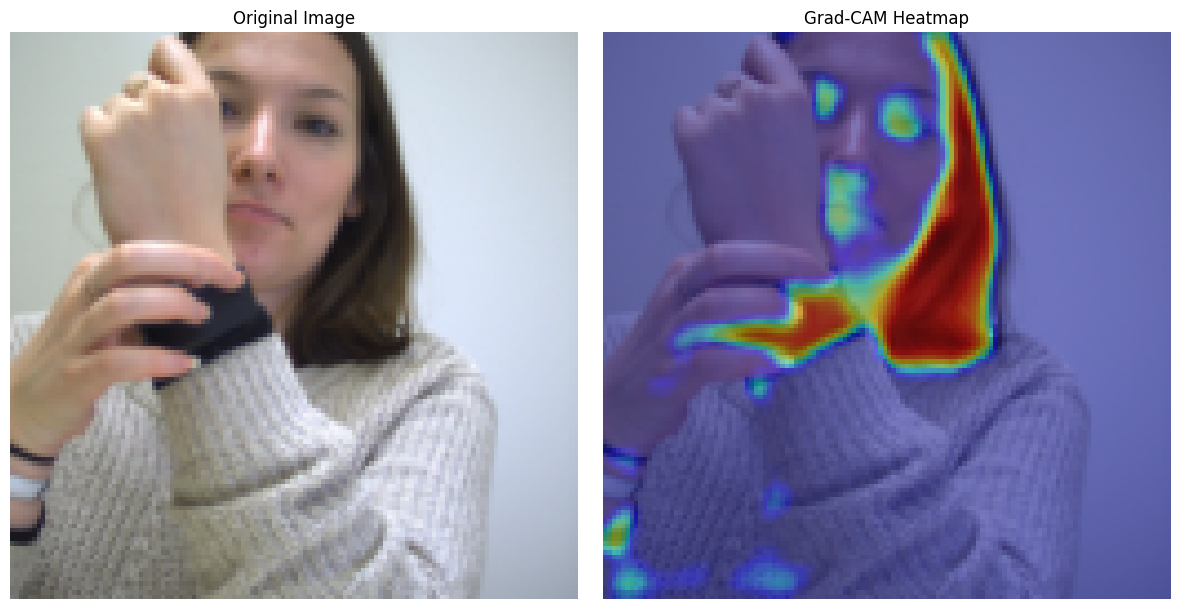

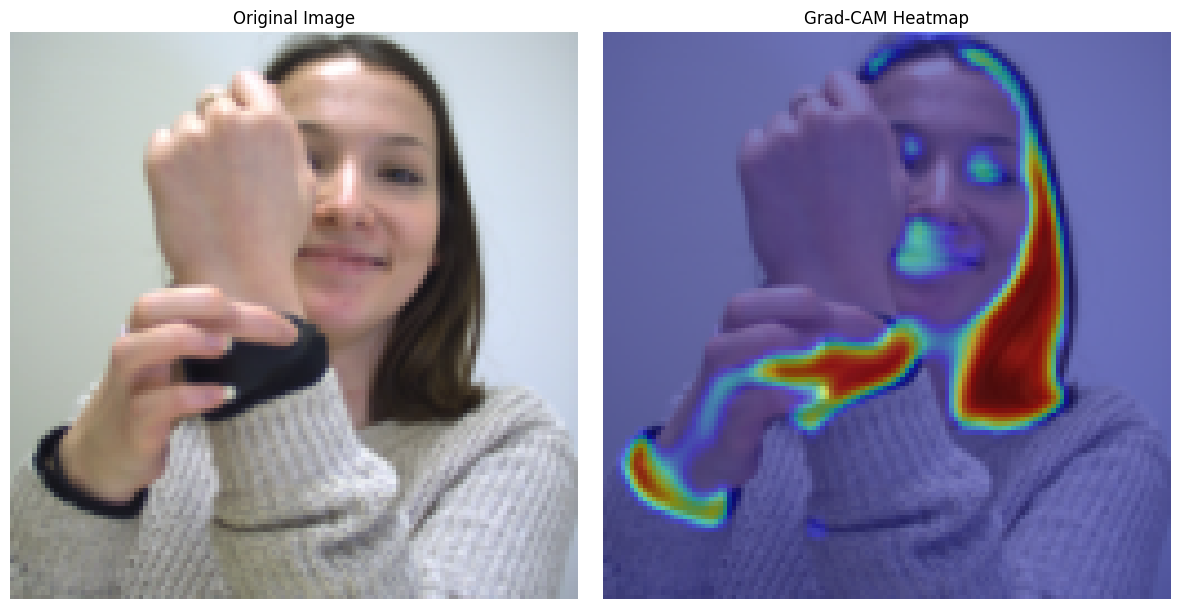

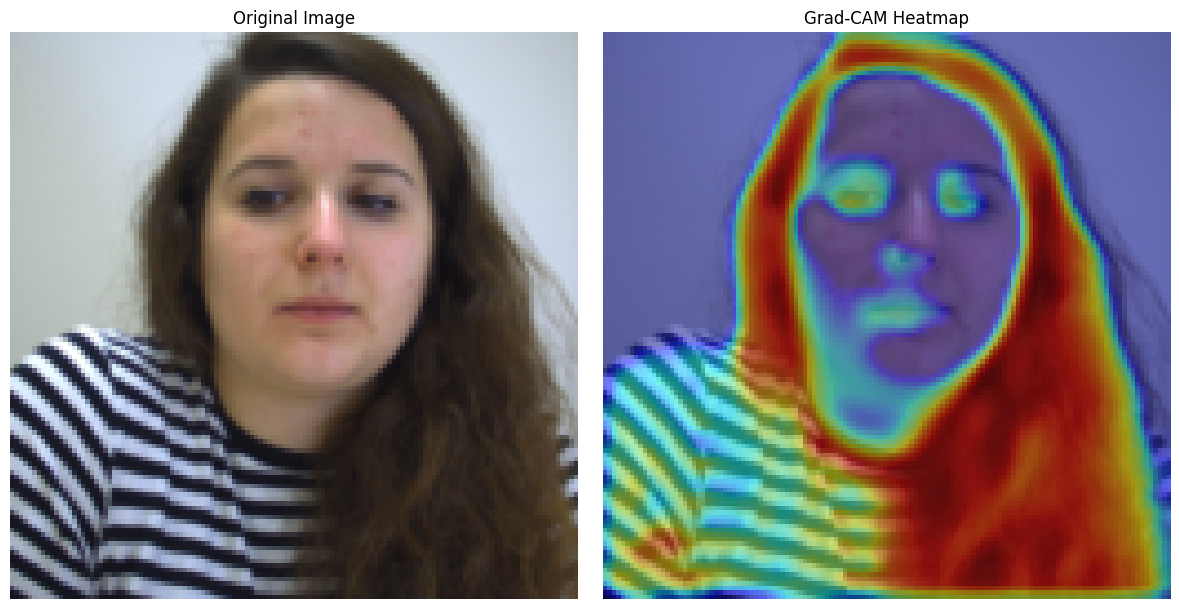

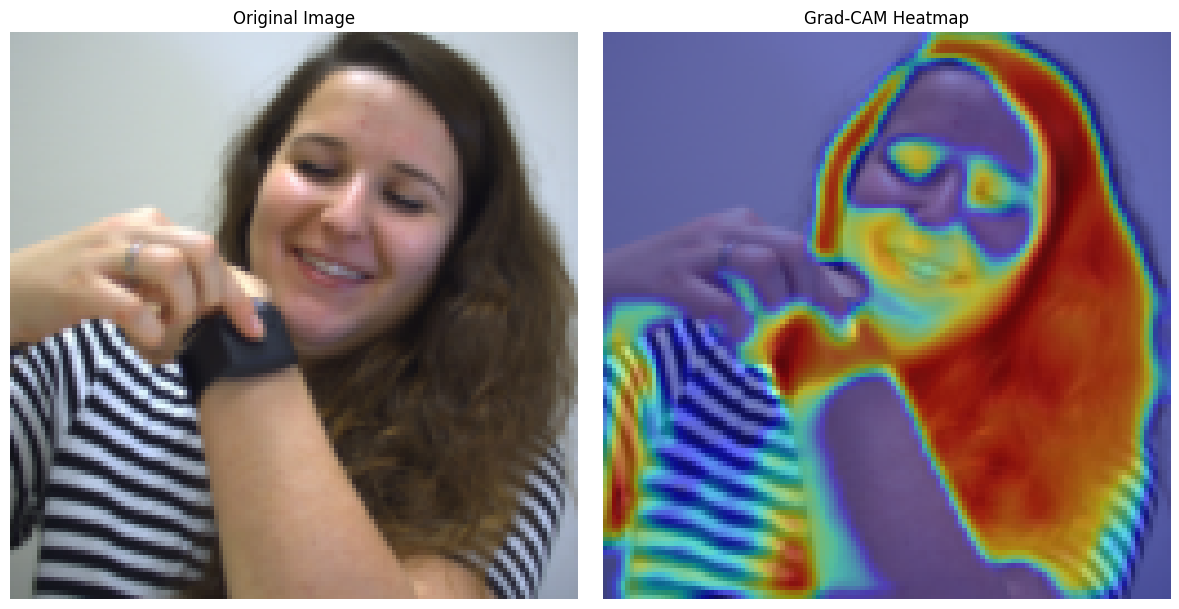

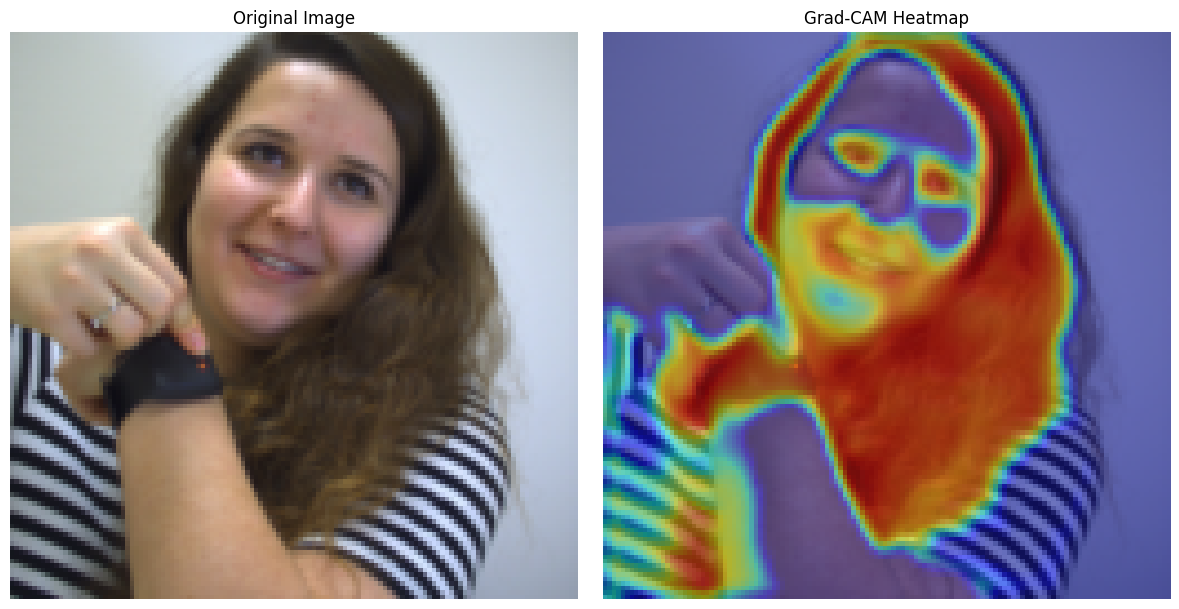

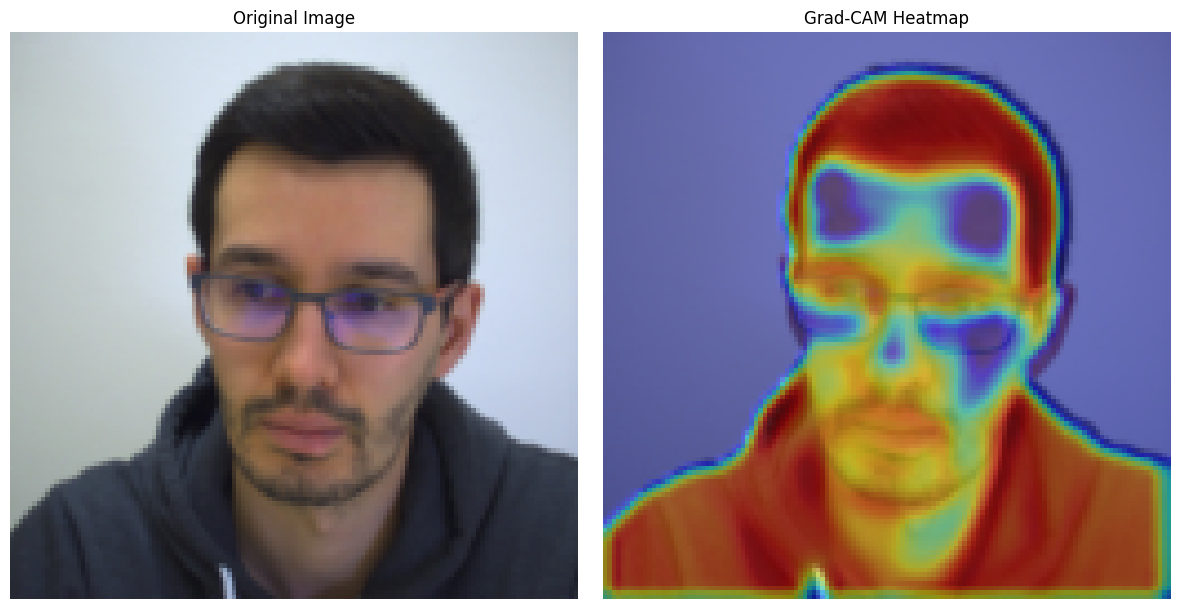

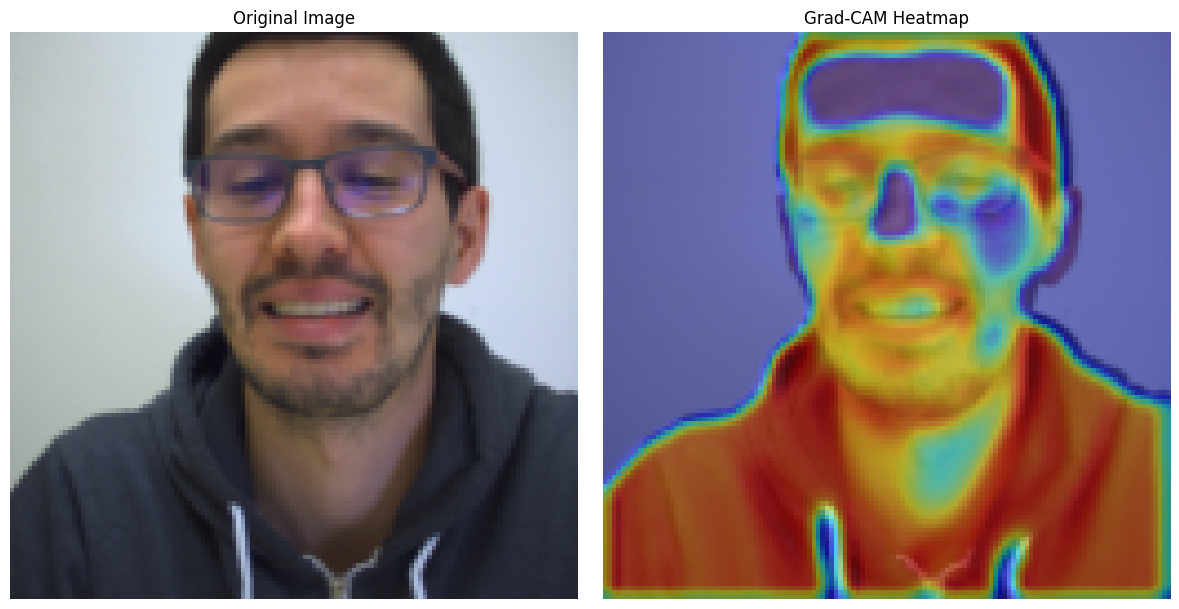

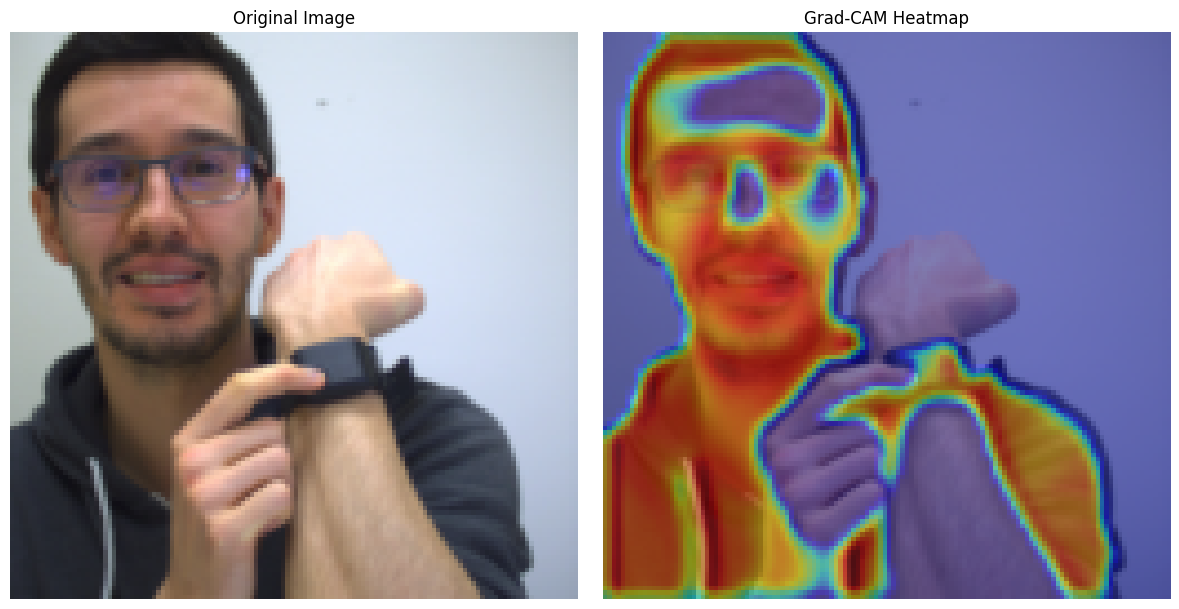

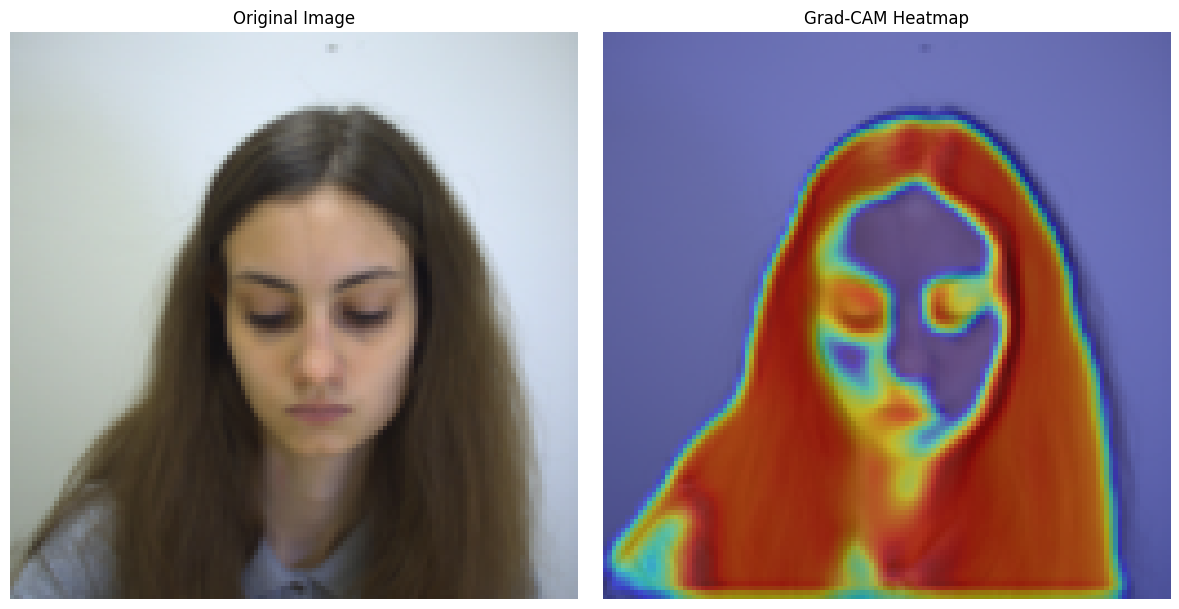

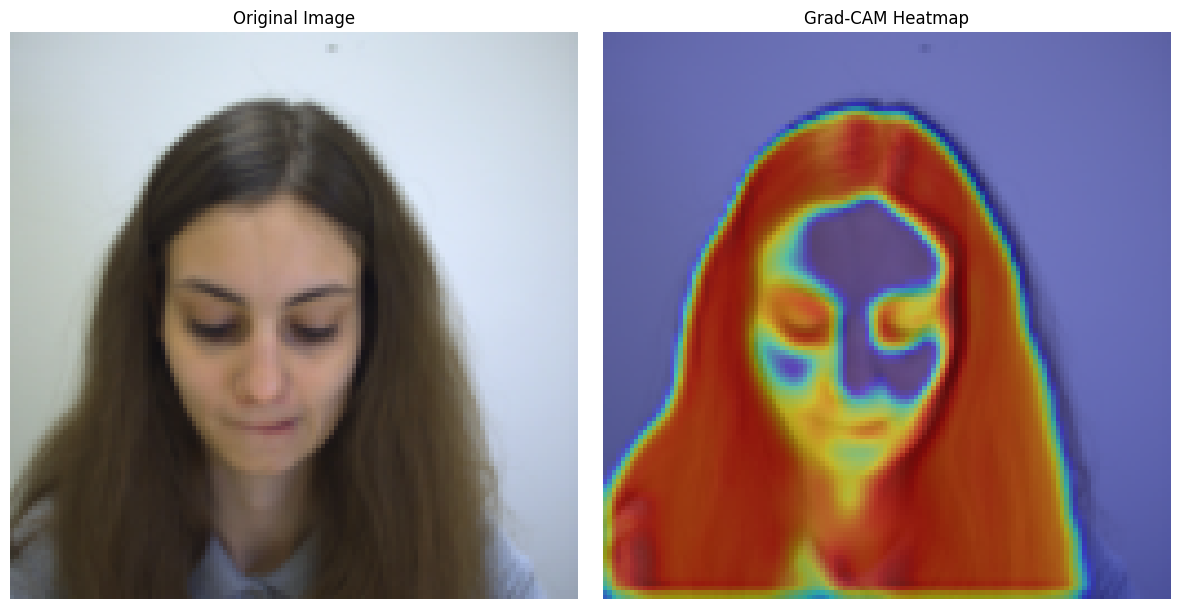

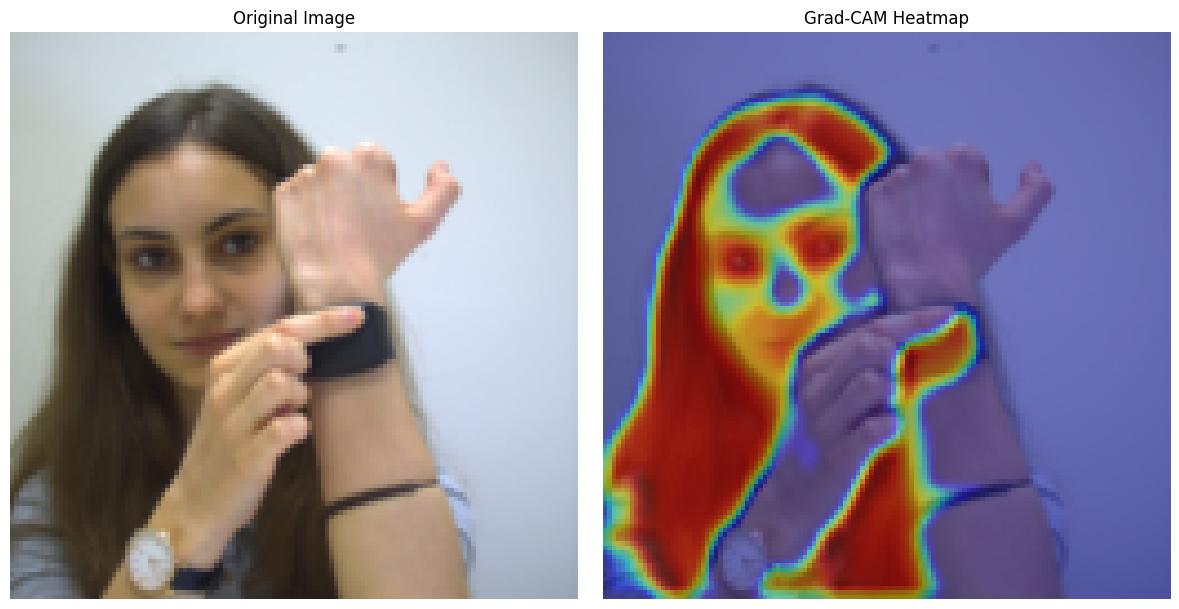

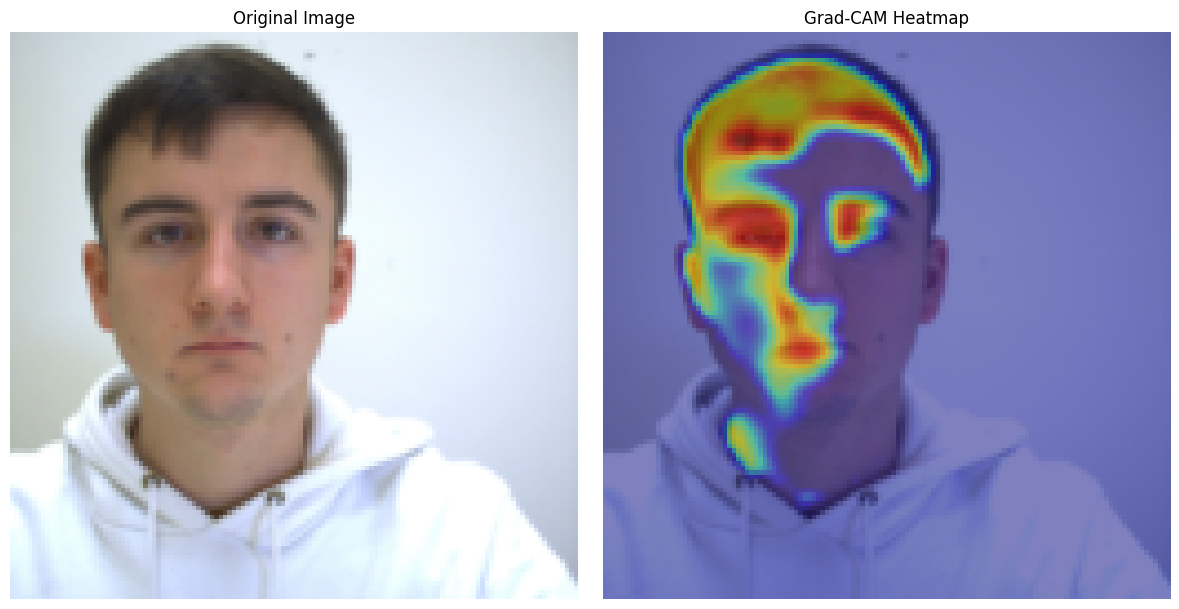

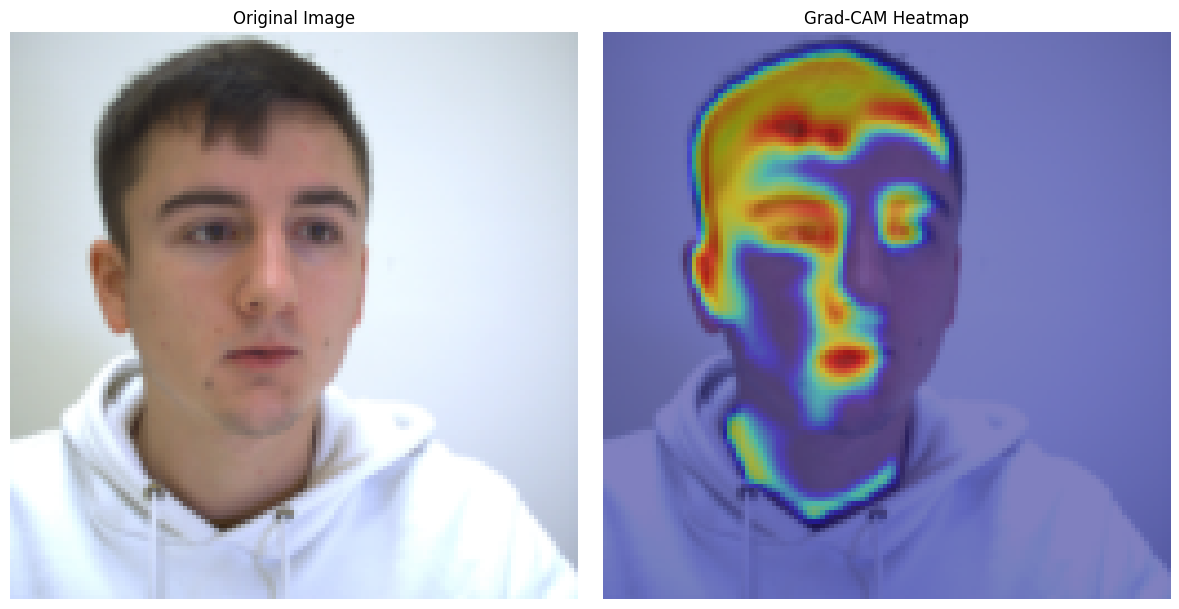

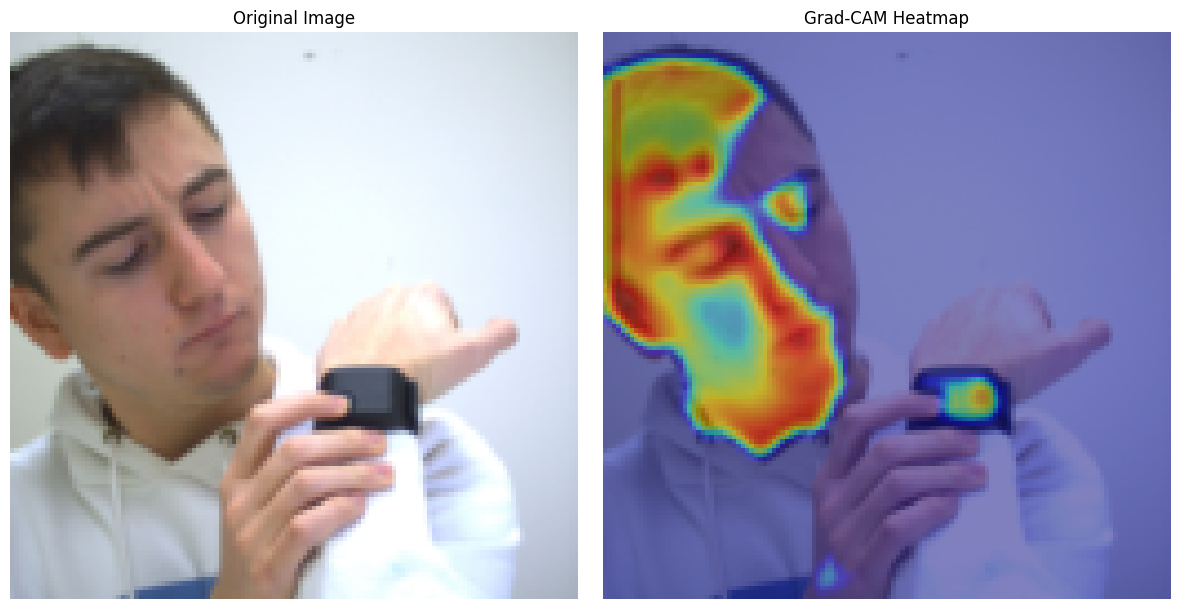

Processing Batches:   0%|          | 0/90 [00:01<?, ?it/s]


In [7]:
visualize_gradcam(
    model=cnn_feature_extractor,
    val_loader=val_loader,
    gradcam_class=GradCAM,
    target_layer=cnn_feature_extractor.conv3,
    num_images=15,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    mean=[0.5, 0.5, 0.5],  # Example for ImageNet
    std=[0.5, 0.5, 0.5],   # Example for ImageNet
    save_plots=False,             # Set to True to save plots
    save_dir='gradcam_plots'      # Directory to save plots if save_plots=True
)
